In [36]:
import glob
import os
import cv2
import numpy as np
import pickle
import torch
from models.gait_cal_sys import GaitEncoding, crop

In [37]:
txt_list_file = r'src/test.txt'
root = r'E:\Gait\dataset'

In [38]:
with open(txt_list_file, 'r', encoding='utf8') as f:
    ids = f.readlines()
    videos_db = []
    target_db = []

    video_at = []
    target_at = []
    for idx in ids:
        vids = os.listdir(os.path.join(root, idx.strip()))
        vids = [os.path.join(root, idx.strip(), v) for v in vids]

        scale = int(len(vids)/2)

        video_at += vids[:scale]
        target_at += [int(idx)] * len(vids[:scale])

        videos_db += vids[scale:]
        target_db += [int(idx)] * len(vids[scale:])

print(len(videos_db), len(video_at))
print(len(target_db), len(target_at))

print(len(set(target_db)))
print(len(set(target_at)))

1979 1968
1979 1968
73
73


In [39]:
def calc_euclidean(feat1, feat2):
    feat1 = feat1.ravel()
    feat2 = feat2.ravel()
    return torch.dot(feat1, feat2) / (torch.linalg.norm(feat1) * torch.linalg.norm(feat2))

model = GaitEncoding()

In [40]:
embeddings_db = []
target_embed_db = []

for idx, vid in zip(target_db, videos_db):
    frames = os.listdir(vid)
    # print(len(frames))
    if len(frames) < 40:
        continue
    try:
        clip = []
        for f in frames[:40]:
            image = cv2.imread(os.path.join(vid, f), 0)
            clip.append(image)
        feat = model(clip)
    except:
        continue
    # print(feat)
    # print(feat.shape)
    embeddings_db.append(feat[0])
    target_embed_db.append(idx)
    # break

print(len(embeddings_db))

1909


In [41]:
truth = []
pred = []

d_means = []
for name, vid in zip(target_at, video_at):
    frames = os.listdir(vid)
    frames.sort()
    # print(len(frames))
    if len(frames) < 40:
        continue

    clip = []
    for f in frames[:40]:
        image = cv2.imread(os.path.join(vid, f), 0)
        clip.append(image)

    feat = model(clip)

    max_d = -1
    predict_name = -1
    for t, a in zip(target_embed_db, embeddings_db):

        d = calc_euclidean(feat[0], a)
        if d > max_d:
            max_d = d
            predict_name = t
        # print(d.item())
    d_means.append(max_d)
    truth.append(name)
    pred.append(predict_name)
    break
# print(truth, pred)
print(sum(d_means)/len(d_means))

C:\Users\Cuong Tran\AppData\Roaming\Python\Python38\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(truth, pred)
acc = accuracy_score(truth, pred)
print(cm)
print(acc)

[[1]]
1.0


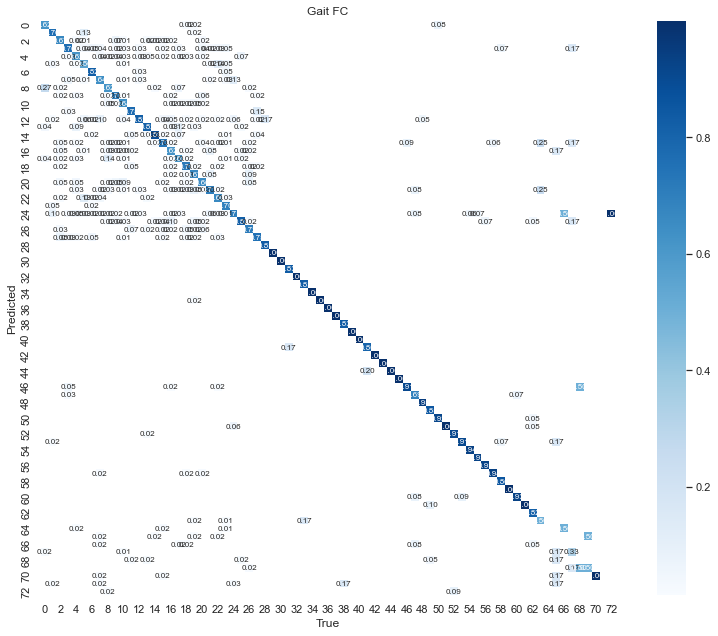

In [15]:
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


def plot_cm(CM, normalize=True, save_dir='', names=(), show=True, title=''):
    if True:
        import seaborn as sn
        array = CM/((CM.sum(0).reshape(1, -1) + 1E-6) if normalize else 1)  # normalize columns
        if not normalize:
            array = np.asarray(array, dtype='int')
        fmt = 'd'
        if normalize:
            fmt = '.2f'
            array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)
        fig = plt.figure(figsize=(12, 9), tight_layout=True)
        sn.set(font_scale=1.0 if 2 < 50 else 0.8)  # for label size
        labels = (0 < len(names) < 99) and len(names) == 2  # apply names to ticklabels
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
            sn.heatmap(array, annot=2 < 30, annot_kws={"size": 8}, cmap='Blues', fmt=fmt, square=True,
                       xticklabels=names if labels else "auto",
                       yticklabels=names if labels else "auto").set_facecolor((1, 1, 1))
        fig.axes[0].set_xlabel('True')
        fig.axes[0].set_ylabel('Predicted')
        fig.axes[0].set_title(title)
        if show:
            plt.show()
        name_save = 'confusion_matrix.png'
        if normalize:
            name_save = 'confusion_matrix_normalize.png'
        fig.savefig(Path(save_dir) / name_save, dpi=250)
        plt.close()

plot_cm(cm, title='Gait FC')